In [1]:
%load_ext autoreload
%load_ext autotime
%autoreload 2

## Imports & Settings

In [2]:
import os, sys
import warnings

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

# disabling log messages from TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# creating an end of run alarm
from IPython.display import Audio
sound_file = '/Users/dsbox/Documents/Flatiron/phase_5/WAILERLP.wav'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
%matplotlib inline

# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette('GnBu_r')
pd.options.display.max_rows = 300

from src import helper_functions as f
from src import visualizations as v
from src import class_Database as d
from src import class_Harness as h

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline 
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             f1_score, make_scorer, confusion_matrix)
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import (BaggingClassifier, AdaBoostClassifier,
                              RandomForestClassifier, VotingClassifier)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_sm_pipeline

# import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

from keras import layers, models, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

time: 12.4 s


## Creating The Database

In [3]:
# creating database & database class instance
database_name = 'outcomes.db'
db = d.Database(database_name)

time: 6.97 ms


**Run The Cell Below Once And Then Comment Out**

In [4]:
# file_name = 'anonymisedData.zip'
# db.populate(file_name, database_name)

time: 634 µs


### Database ERD

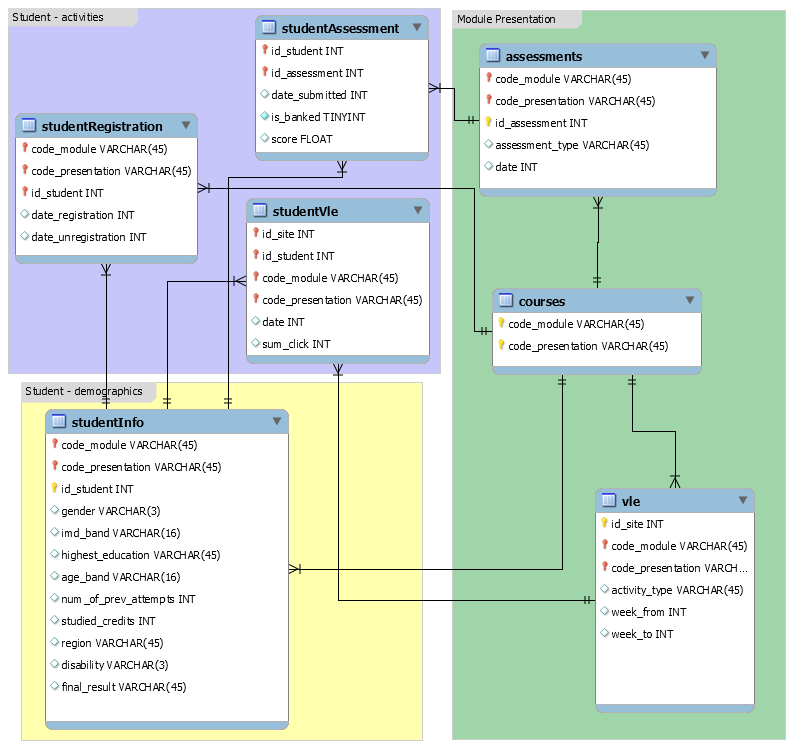

time: 4.19 ms


In [5]:
db.erd

## Preprocessing and Harness Objects

In [6]:
string_selector = make_column_selector(dtype_include='object')
number_selector = make_column_selector(dtype_include='number', dtype_exclude='object')

preprocessing_ohe = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector))
preprocessing_ss = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (StandardScaler(), number_selector))
preprocessing_mm = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (MinMaxScaler(), number_selector))
sm = SMOTE(random_state=2021)

time: 2.53 ms


In [7]:
# creating accuracy scorer
accuracy = f.acc_score

# creating f1 scorer
f1 = f.f1

# creating recall scorer 
recall = f.recall

# creating precision scorer
precision = f.precision

# creating Harness
modeling = h.Harness(('accuracy', 'f1', 'recall', 'precision'))

time: 3.72 ms


In [8]:
path = os.path.join(gparent, 'data/processed/q2.csv')
df = pd.read_csv(path)

time: 91.5 ms


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24770 entries, 0 to 24769
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   score                 22202 non-null  float64
 1   gender                22219 non-null  object 
 2   region                22219 non-null  object 
 3   highest_education     22219 non-null  object 
 4   imd_band              21332 non-null  object 
 5   age_band              22219 non-null  object 
 6   num_of_prev_attempts  22219 non-null  float64
 7   studied_credits       22219 non-null  float64
 8   disability            22219 non-null  object 
 9   final_result          22219 non-null  object 
 10  date_sub              22219 non-null  float64
 11  course_length         22219 non-null  float64
 12  row_id                24770 non-null  object 
 13  target                22219 non-null  float64
 14  weighted_ave          22217 non-null  float64
 15  mean_score         

In [10]:
df.describe()

,score,num_of_prev_attempts,studied_credits,date_sub,course_length,target,weighted_ave,mean_score,median_score,date,id_site,date.1,sum_click,click_sum,num_activities,date_registration,date_unregistration
count,22202.000000,22219.000000,22219.000000,22219.000000,22219.000000,22219.000000,22217.000000,22217.000000,22217.000000,22219.000000,22219.000000,22219.000000,22219.000000,22219.000000,22219.000000,24770.000000,2255.000000
mean,73.492523,0.146496,75.465142,25.178541,239.721995,0.327918,113.110186,75.296531,75.653936,-4.346325,744075.783024,-4.346325,2.747918,243.091273,70.695846,-65.488736,170.795565
std,20.958447,0.453636,37.220055,14.311197,5.701796,0.469465,65.361515,14.850148,14.772224,27.225546,125709.321062,27.225546,5.802341,307.476607,67.925893,47.117116,33.475645
min,0.000000,0.000000,30.000000,-11.000000,234.000000,0.000000,0.000000,0.000000,0.000000,-25.000000,526721.000000,-25.000000,1.000000,1.000000,1.000000,-311.000000,121.000000
25%,65.000000,0.000000,60.000000,18.000000,240.000000,0.000000,68.800000,67.666667,68.000000,-17.000000,673519.000000,-17.000000,1.000000,56.000000,23.000000,-94.000000,144.000000
50%,78.000000,0.000000,60.000000,21.000000,240.000000,0.000000,120.560000,78.333333,78.000000,-10.000000,768351.000000,-10.000000,1.000000,140.000000,50.000000,-52.000000,165.000000
75%,88.000000,0.000000,90.000000,31.000000,241.000000,1.000000,159.000000,86.000000,86.000000,-5.000000,832780.000000,-5.000000,3.000000,313.000000,95.000000,-29.000000,198.000000
max,100.000000,6.000000,630.000000,119.000000,268.000000,1.000000,303.840000,100.000000,100.000000,119.000000,947016.000000,119.000000,511.000000,5675.000000,658.000000,167.000000,444.000000


time: 84.5 ms


In [11]:
f.col_pop(df, 'target')
f.col_pop(df, 'row_id', 1)
conversions = ['target', 'studied_credits']
df[conversions] = df[conversions].apply(pd.to_numeric)
# adding course_load column
df['course_load'] = pd.qcut(df.studied_credits, q=4,\
                                labels=['Light', 'Medium', 'Heavy'],\
                                duplicates='drop')

time: 29.8 ms


In [12]:
df.shape

(24770, 26)

time: 2.13 ms


In [13]:
df['imd_band'] = df['imd_band'].replace(['10-20'], '10-20%')
# renaming values
df['disability'] = df['disability'].replace(['Y', 'N'], ['Yes', 'No'])
df['gender'] = df['gender'].replace(['M', 'F'], ['Male', 'Female'])

time: 13.5 ms


In [14]:
df.shape

(24770, 26)

time: 2.35 ms


In [15]:
Q1 = df.studied_credits.quantile(0.25)
Q3 = df.studied_credits.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df.studied_credits < (Q1 - 1.5 * IQR))\
                        |(df.studied_credits > (Q3 + 1.5 * IQR)))].copy()
           
Q1 = df.weighted_ave.quantile(0.25)
Q3 = df.weighted_ave.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df.weighted_ave < (Q1 - 1.5 * IQR))\
                        |(df.weighted_ave > (Q3 + 1.5 * IQR)))].copy()

time: 16.8 ms


In [16]:
df.shape

(23584, 26)

time: 2.6 ms


In [17]:
drops = ['row_id', 'studied_credits', 'final_result',
         'id_site' ,'date', 'sum_click', 'date_sub',
         'score','course_length', 'date_registration',
         'date_unregistration']

time: 1 ms


In [18]:
df = df.drop(drops, axis=1)

time: 3.6 ms


In [19]:
df.shape

(23584, 15)

time: 3.07 ms


In [20]:
df = df.dropna()

time: 11.7 ms


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20196 entries, 1 to 24769
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   target                20196 non-null  float64 
 1   gender                20196 non-null  object  
 2   region                20196 non-null  object  
 3   highest_education     20196 non-null  object  
 4   imd_band              20196 non-null  object  
 5   age_band              20196 non-null  object  
 6   num_of_prev_attempts  20196 non-null  float64 
 7   disability            20196 non-null  object  
 8   weighted_ave          20196 non-null  float64 
 9   mean_score            20196 non-null  float64 
 10  median_score          20196 non-null  float64 
 11  date.1                20196 non-null  float64 
 12  click_sum             20196 non-null  float64 
 13  num_activities        20196 non-null  float64 
 14  course_load           20196 non-null  category
dtypes:

In [22]:
df.target.value_counts(normalize=True)

0.0    0.671024
1.0    0.328976
Name: target, dtype: float64

time: 5.49 ms


## Creating Holdout Data

In [23]:
# splitting data & target
X, y = f.X_y(df)

time: 3.3 ms


In [24]:
# splitting traing and holdout data
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 13.1 ms


## Creating Training Data

In [25]:
# train test split
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

time: 11.8 ms


# SS Test

## KNeighborsClassifier

In [26]:
KNN = KNeighborsClassifier(n_jobs=-1)

time: 934 µs


In [27]:
knn_ss = make_pipeline(preprocessing_ss, KNN)

time: 1.06 ms


### Fitting Model

In [28]:
knn_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10fb62730>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16612b9a0>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

time: 68.2 ms


In [29]:
# f.pickle_model(knn_ss, 'knn_ss')

time: 791 µs


### Cross Val Scores

In [30]:
# checking cross val scores
modeling.report(knn_ss, X_train, y_train, 'knn_ss',\
                'KNN SS()')

knn_ss has an average Accuracy of 0.727024647887324
knn_ss has an average F1 of 0.5363474962562256
knn_ss has an average Recall of 0.4800682229810508
knn_ss has an average Precision of 0.6076356987905304
time: 4.08 s


### Test Data Confusion Matrix

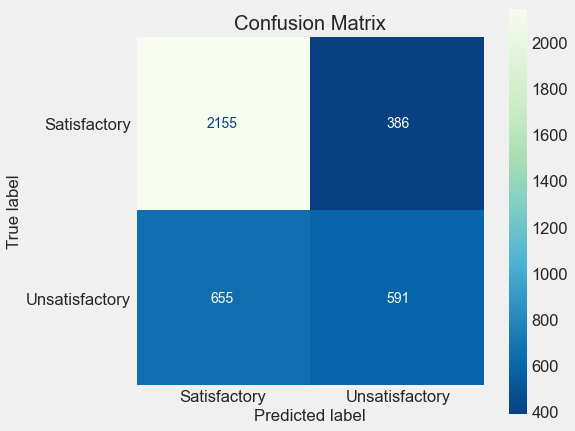

,Accuracy,F1,Recall,Precision
0,0.725112,0.531714,0.474318,0.604913


time: 8.03 s


In [31]:
f.confusion_report(knn_ss, X_test, y_test)

## Logistic Regression Classifier

In [32]:
LR = LogisticRegression(max_iter=1000, n_jobs=-1, random_state = 2021, verbose=0)

time: 1.17 ms


In [33]:
logreg_ss = make_pipeline(preprocessing_ss, LR)

time: 1.04 ms


### Fitting Model

In [34]:
logreg_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10fb62730>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16612b9a0>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1,
                                    random_state=2021))])

time: 4.54 s


In [35]:
# f.pickle_model(logreg_ss, 'logreg_ss')

time: 1.3 ms


### Cross Val Scores

In [36]:
# checking cross val scores
modeling.report(logreg_ss, X_train, y_train, 'logreg_ss',\
                'LogReg SS()')

logreg_ss has an average Accuracy of 0.7512323943661972
logreg_ss has an average F1 of 0.5478929081644301
logreg_ss has an average Recall of 0.4583893506288971
logreg_ss has an average Precision of 0.6813548071548917
time: 8.98 s


### Test Data Confusion Matrix

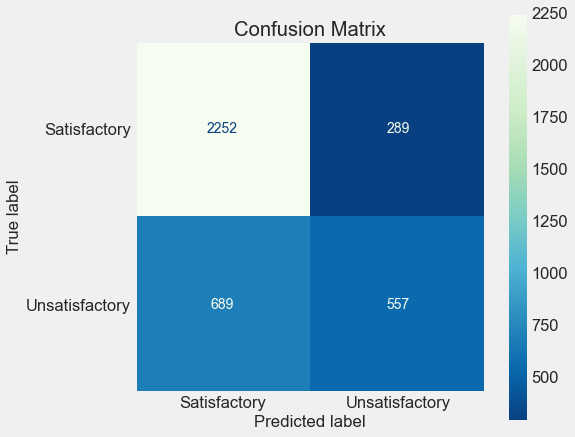

,Accuracy,F1,Recall,Precision
0,0.741748,0.532505,0.44703,0.658392


time: 308 ms


In [37]:
f.confusion_report(logreg_ss, X_test, y_test)

## Support Vector Machine

In [38]:
SVC = SVC()

time: 937 µs


In [39]:
svc_ss = make_pipeline(preprocessing_ss, SVC)

time: 936 µs


### Fitting Model

In [40]:
svc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10fb62730>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16612b9a0>)])),
                ('svc', SVC())])

time: 5.36 s


In [41]:
# f.pickle_model(svc_ss, 'svc_ss')

time: 823 µs


### Cross Val Scores

In [42]:
# checking cross val scores
modeling.report(svc_ss, X_train, y_train, 'svc_ss',\
                'Support Vector CLF SS()')

svc_ss has an average Accuracy of 0.7580985915492958
svc_ss has an average F1 of 0.5492201321677881
svc_ss has an average Recall of 0.4479572478863762
svc_ss has an average Precision of 0.7097439049639255
time: 26.9 s


### Test Data Confusion Matrix

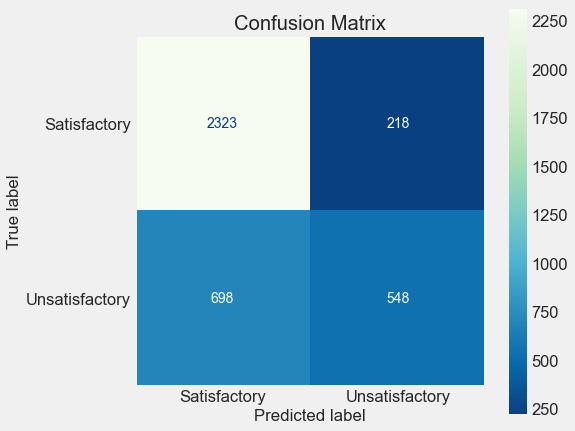

,Accuracy,F1,Recall,Precision
0,0.75812,0.544732,0.439807,0.715405


time: 23.7 s


In [43]:
f.confusion_report(svc_ss, X_test, y_test)

## Linear Support Vector Machine

In [44]:
LSVC = LinearSVC()

time: 995 µs


In [45]:
lsvc_ss = make_pipeline(preprocessing_ss, LSVC)

time: 1.61 ms


### Fitting Model

In [46]:
lsvc_ss.fit(X_train, y_train)

/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10fb62730>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16612b9a0>)])),
                ('linearsvc', LinearSVC())])

time: 766 ms


In [47]:
# f.pickle_model(lsvc_ss, 'lsvc_ss')

time: 780 µs


### Cross Val Scores

In [48]:
# checking cross val scores
modeling.report(lsvc_ss, X_train, y_train, 'lsvc_ss',\
                'Linear SVC SS()')

/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


lsvc_ss has an average Accuracy of 0.749031690140845
lsvc_ss has an average F1 of 0.5351799740302206
lsvc_ss has an average Recall of 0.43939322351795773
lsvc_ss has an average Precision of 0.6848971630814059
time: 3.68 s


/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


### Test Data Confusion Matrix

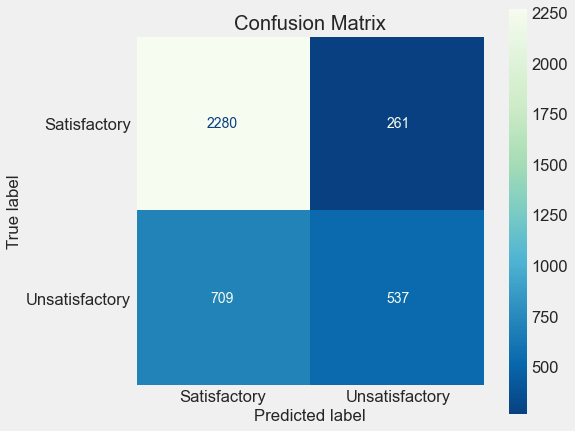

,Accuracy,F1,Recall,Precision
0,0.743861,0.52544,0.430979,0.672932


time: 366 ms


In [49]:
f.confusion_report(lsvc_ss, X_test, y_test)

## Decision Tree

In [50]:
DT = DecisionTreeClassifier(random_state=2021)

time: 989 µs


In [51]:
dt_ss = make_pipeline(preprocessing_ss, DT)

time: 1.4 ms


### Fitting Model

In [52]:
dt_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10fb62730>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16612b9a0>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

time: 146 ms


In [53]:
# f.pickle_model(dt_ss, 'dt_ss')

time: 805 µs


### Cross Val Scores

In [54]:
# checking cross val scores
modeling.report(dt_ss, X_train, y_train, 'dt_ss',\
                'Decision Tree CLF SS()')

dt_ss has an average Accuracy of 0.6930457746478873
dt_ss has an average F1 of 0.5410785315577439
dt_ss has an average Recall of 0.550169304669659
dt_ss has an average Precision of 0.5323563749387747
time: 588 ms


### Test Data Confusion Matrix

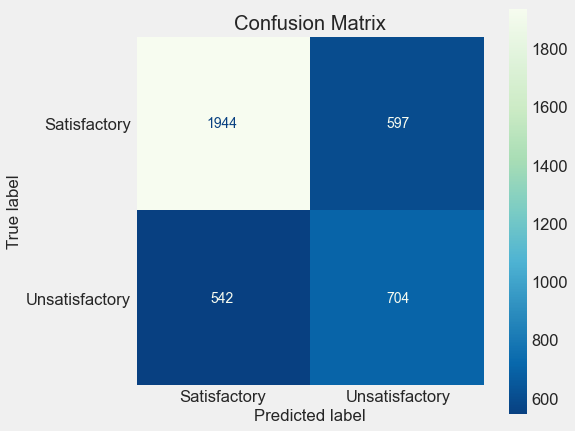

,Accuracy,F1,Recall,Precision
0,0.699234,0.552807,0.565008,0.541122


time: 225 ms


In [55]:
f.confusion_report(dt_ss, X_test, y_test)

## Bagging Classifier

In [56]:
BCLF = BaggingClassifier(base_estimator=DT, random_state=2021)

time: 1.06 ms


In [57]:
bclf_ss = make_pipeline(preprocessing_ss, BCLF)

time: 1.68 ms


### Fitting Model

In [58]:
bclf_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10fb62730>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16612b9a0>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 686 ms


In [59]:
# f.pickle_model(bclf_ss, 'bclf_ss')

time: 923 µs


### Cross Val Scores

In [60]:
# checking cross val scores
modeling.report(bclf_ss, X_train, y_train, 'bclf_ss',\
                'Bagging CLF SS()')

bclf_ss has an average Accuracy of 0.759242957746479
bclf_ss has an average F1 of 0.575552173196219
bclf_ss has an average Recall of 0.49612353155939265
bclf_ss has an average Precision of 0.685569551864311
time: 2.71 s


### Test Data Confusion Matrix

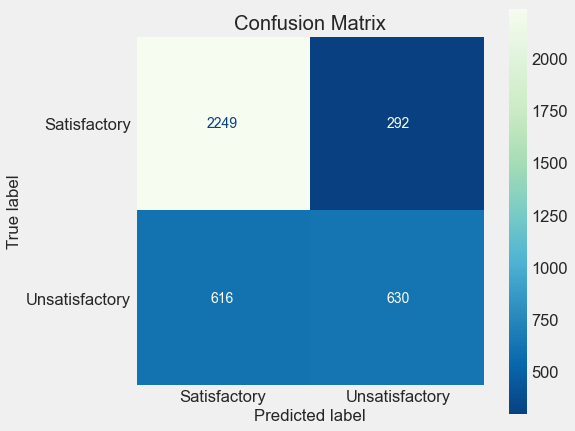

,Accuracy,F1,Recall,Precision
0,0.760232,0.581181,0.505618,0.683297


time: 319 ms


In [61]:
f.confusion_report(bclf_ss, X_test, y_test)

## Random Forest Classifier

In [62]:
RF = RandomForestClassifier(n_jobs=-1, random_state=2021)

time: 1.11 ms


In [63]:
rf_ss = make_pipeline(preprocessing_ss, RF)

time: 1.34 ms


### Fitting Model

In [64]:
rf_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10fb62730>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16612b9a0>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 672 ms


In [65]:
# f.pickle_model(rf_ss, 'rf_ss')

time: 1.65 ms


### Cross Val Scores

In [66]:
# checking cross val scores
modeling.report(rf_ss, X_train, y_train, 'rf_ss',\
                'Random Forest SS()')

rf_ss has an average Accuracy of 0.7727992957746478
rf_ss has an average F1 of 0.6028377940457438
rf_ss has an average Recall of 0.5242241694048924
rf_ss has an average Precision of 0.7095305176418865
time: 6.4 s


### Test Data Confusion Matrix

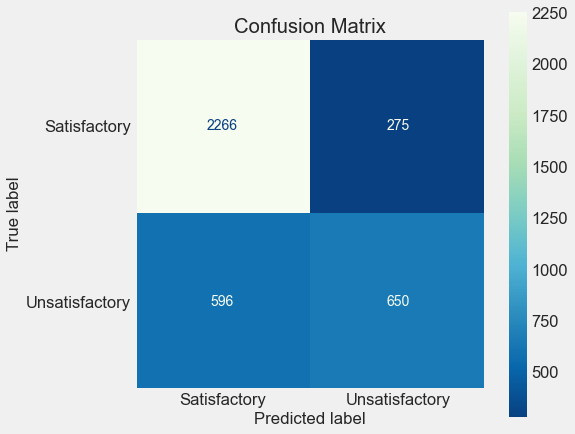

,Accuracy,F1,Recall,Precision
0,0.770003,0.598802,0.521669,0.702703


time: 503 ms


In [67]:
f.confusion_report(rf_ss, X_test, y_test)

## AdaBoost

In [68]:
ADA = AdaBoostClassifier(base_estimator=DT, random_state=2021)

time: 980 µs


In [69]:
ada_ss = make_pipeline(preprocessing_ss, ADA)

time: 1.13 ms


### Fitting Model

In [70]:
ada_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10fb62730>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16612b9a0>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                    random_state=2021))])

time: 161 ms


In [71]:
# f.pickle_model(ada_ss, 'ada_ss')

time: 1.07 ms


### Cross Val Scores

In [72]:
# checking cross val scores
modeling.report(ada_ss, X_train, y_train, 'ada_ss',\
                'AdaBoost SS()')

ada_ss has an average Accuracy of 0.6921654929577465
ada_ss has an average F1 of 0.5395496709606946
ada_ss has an average Recall of 0.5483019421715383
ada_ss has an average Precision of 0.5311537998366559
time: 812 ms


### Test Data Confusion Matrix

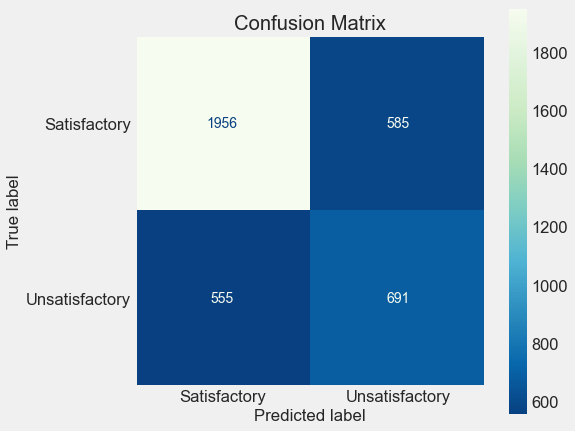

,Accuracy,F1,Recall,Precision
0,0.69897,0.547978,0.554575,0.541536


time: 268 ms


In [73]:
f.confusion_report(ada_ss, X_test, y_test)

## XGBoost

In [74]:
XGB = XGBClassifier(use_label_encoder=False, verbosity=0)

time: 1.19 ms


In [75]:
xgb_ss = make_pipeline(preprocessing_ss, XGB)

time: 1.13 ms


### Fitting Model

In [76]:
%%capture --no-display
xgb_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10fb62730>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16612b9a0>)])),
                ('xgbclassifier',
                 XGBClassifie...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estima

time: 1.57 s


In [77]:
# f.pickle_model(xgb_ss, 'xgb_ss')

time: 1.61 ms


### Cross Val Scores

In [78]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb_ss, X_train, y_train, 'xgb_ss',\
                'XGBoost SS()')

time: 7.02 s


### Test Data Confusion Matrix

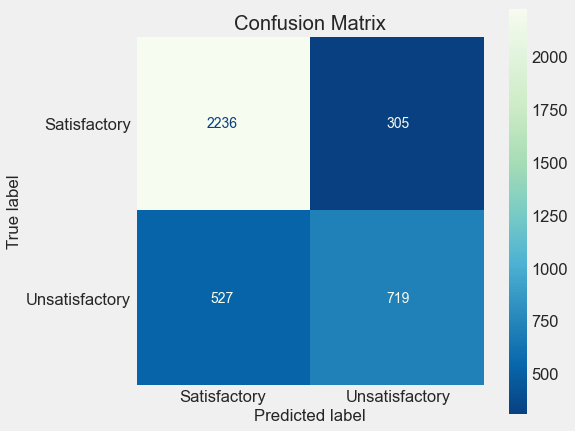

,Accuracy,F1,Recall,Precision
0,0.780301,0.63348,0.577047,0.702148


time: 367 ms


In [79]:
%%capture --no-display
f.confusion_report(xgb_ss, X_test, y_test)

## Model Summary 8

In [80]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,lsvc_ss,0.749032,0.535180,0.439393,0.684897,3.675846,Linear SVC SS()
1,svc_ss,0.758099,0.549220,0.447957,0.709744,26.867174,Support Vector CLF SS()
2,logreg_ss,0.751232,0.547893,0.458389,0.681355,8.969244,LogReg SS()
3,knn_ss,0.727025,0.536347,0.480068,0.607636,4.067252,KNN SS()
4,bclf_ss,0.759243,0.575552,0.496124,0.685570,2.703265,Bagging CLF SS()
5,rf_ss,0.772799,0.602838,0.524224,0.709531,6.399464,Random Forest SS()
6,ada_ss,0.692165,0.539550,0.548302,0.531154,0.808926,AdaBoost SS()
7,dt_ss,0.693046,0.541079,0.550169,0.532356,0.584222,Decision Tree CLF SS()
8,xgb_ss,0.771655,0.618429,0.562485,0.686756,7.017084,XGBoost SS()


time: 10.8 ms


## Voting Classifier
Using the top three model in a voting classifier.

In [81]:
clf1 = BCLF
clf2 = RF
clf3 = XGB

estimators = [('bclf',clf1), ('rf', clf2), ('xgb', clf3)]

VC = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)

time: 1.56 ms


In [82]:
vc_ss = make_pipeline(preprocessing_ss, VC)

time: 1.17 ms


### Fitting Model

In [83]:
%%capture --no-display
vc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10fb62730>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16612b9a0>)])),
                ('votingclassifier',
                 VotingCla...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
   

time: 3.23 s


In [84]:
# f.pickle_model(vc_ss, 'vc_ss')

time: 636 µs


### Cross Val Scores

In [85]:
%%capture --no-display
# checking cross val scores
modeling.report(vc_ss, X_train, y_train, 'vc_ss',\
                'Voting CLF SS()')

time: 14.9 s


### Test Data Confusion Matrix

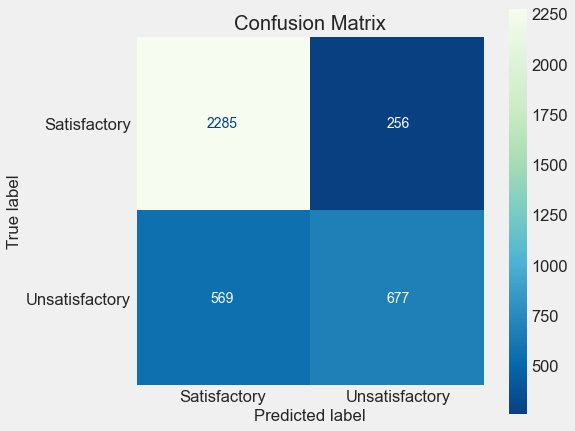

,Accuracy,F1,Recall,Precision
0,0.782149,0.621386,0.543339,0.725616


time: 1.05 s


In [86]:
%%capture --no-display
f.confusion_report(vc_ss, X_test, y_test)

## Model Summary

In [87]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,lsvc_ss,0.749032,0.535180,0.439393,0.684897,3.675846,Linear SVC SS()
1,svc_ss,0.758099,0.549220,0.447957,0.709744,26.867174,Support Vector CLF SS()
2,logreg_ss,0.751232,0.547893,0.458389,0.681355,8.969244,LogReg SS()
3,knn_ss,0.727025,0.536347,0.480068,0.607636,4.067252,KNN SS()
4,bclf_ss,0.759243,0.575552,0.496124,0.685570,2.703265,Bagging CLF SS()
5,rf_ss,0.772799,0.602838,0.524224,0.709531,6.399464,Random Forest SS()
9,vc_ss,0.776673,0.610678,0.532519,0.716097,14.864630,Voting CLF SS()
6,ada_ss,0.692165,0.539550,0.548302,0.531154,0.808926,AdaBoost SS()
7,dt_ss,0.693046,0.541079,0.550169,0.532356,0.584222,Decision Tree CLF SS()
8,xgb_ss,0.771655,0.618429,0.562485,0.686756,7.017084,XGBoost SS()


time: 15.5 ms


## Neural Network

### Create Model

In [88]:
def create_model():
    # building model
    model = Sequential()
    model.add(Dense(64, input_dim=42, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    return model

time: 1.59 ms


In [89]:
NN = KerasClassifier(build_fn=create_model,
                     epochs=10,
                     batch_size=32,
                     verbose=0)

time: 1.59 ms


### Pipeline

In [90]:
nn_ss = make_pipeline(preprocessing_ss, NN)

time: 1.47 ms


### Fitting Models

In [91]:
%%capture --no-display
nn_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10fb62730>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16612b9a0>)])),
                ('kerasclassifier',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x1c064e580>)])

time: 5.2 s


In [92]:
# f.pickle_model(nn_ss, 'nn_ss')

time: 907 µs


### Cross Val Scores

In [93]:
%%capture --no-display
modeling.report(nn_ss, X_train, y_train, 'nn_ss',\
                'Neural Net SS()')

time: 16.3 s


### Test Data Confusion Matrix

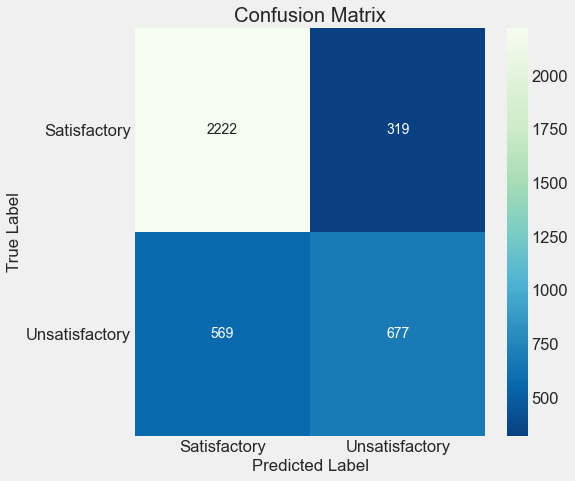

,Accuracy,F1,Recall,Precision
0,0.765514,0.603925,0.543339,0.679719


time: 708 ms


In [94]:
%%capture --no-display
f.confusion_report_nn(nn_ss, X_test, y_test)

## Model Summary

In [95]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,lsvc_ss,0.749032,0.535180,0.439393,0.684897,3.675846,Linear SVC SS()
1,svc_ss,0.758099,0.549220,0.447957,0.709744,26.867174,Support Vector CLF SS()
2,logreg_ss,0.751232,0.547893,0.458389,0.681355,8.969244,LogReg SS()
3,knn_ss,0.727025,0.536347,0.480068,0.607636,4.067252,KNN SS()
4,bclf_ss,0.759243,0.575552,0.496124,0.685570,2.703265,Bagging CLF SS()
10,nn_ss,0.757218,0.584370,0.521733,0.671488,16.289780,Neural Net SS()
5,rf_ss,0.772799,0.602838,0.524224,0.709531,6.399464,Random Forest SS()
6,vc_ss,0.776673,0.610678,0.532519,0.716097,14.864630,Voting CLF SS()
7,ada_ss,0.692165,0.539550,0.548302,0.531154,0.808926,AdaBoost SS()
8,dt_ss,0.693046,0.541079,0.550169,0.532356,0.584222,Decision Tree CLF SS()


time: 13.4 ms


In [96]:
clf1 = BCLF
clf2 = RF
clf3 = XGB

estimators = [('bclf', clf1), ('rf', clf2), ('xgb', clf3)]
VC = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)

time: 1.94 ms


In [97]:
vc_ss = make_sm_pipeline(preprocessing_ss, sm, VC)

time: 1.16 ms


### Fitting Model

In [98]:
%%capture --no-display
vc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10fb62730>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16612b9a0>)])),
                ('smote', SMOTE(random_state=2...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
                    

time: 4.39 s


In [99]:
# f.pickle_model(vc_ss, 'vc_ss')

time: 723 µs


### Cross Val Scores

In [100]:
%%capture --no-display
# checking cross val scores
modeling.report(vc_ss, X_train, y_train, 'vc_ss',\
                'Voting CLF SS()/SMOTE')

time: 18.9 s


### Test Data Confusion Matrix

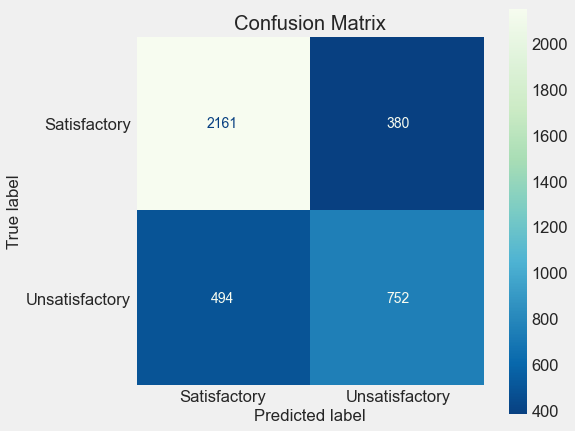

,Accuracy,F1,Recall,Precision
0,0.76921,0.632464,0.603531,0.664311


time: 1.11 s


In [101]:
%%capture --no-display
f.confusion_report(vc_ss, X_test, y_test)

## Model Summary

In [102]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,lsvc_ss,0.749032,0.535180,0.439393,0.684897,3.675846,Linear SVC SS()
1,svc_ss,0.758099,0.549220,0.447957,0.709744,26.867174,Support Vector CLF SS()
2,logreg_ss,0.751232,0.547893,0.458389,0.681355,8.969244,LogReg SS()
3,knn_ss,0.727025,0.536347,0.480068,0.607636,4.067252,KNN SS()
4,bclf_ss,0.759243,0.575552,0.496124,0.685570,2.703265,Bagging CLF SS()
5,nn_ss,0.757218,0.584370,0.521733,0.671488,16.289780,Neural Net SS()
6,rf_ss,0.772799,0.602838,0.524224,0.709531,6.399464,Random Forest SS()
7,vc_ss,0.776673,0.610678,0.532519,0.716097,14.864630,Voting CLF SS()
8,ada_ss,0.692165,0.539550,0.548302,0.531154,0.808926,AdaBoost SS()
9,dt_ss,0.693046,0.541079,0.550169,0.532356,0.584222,Decision Tree CLF SS()


time: 14.7 ms


## Neural Network SMOTE

### Pipeline

In [103]:
nn_sm = make_sm_pipeline(preprocessing_ss, sm, NN)

time: 1.21 ms


### Fitting Models

In [104]:
%%capture --no-display
nn_sm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10fb62730>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16612b9a0>)])),
                ('smote', SMOTE(random_state=2021)),
                ('kerasclassifier',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x1c064e580>)])

time: 5.83 s


In [105]:
# f.pickle_model(nn_ss, 'nn_ss')

time: 808 µs


### Cross Val Scores

In [106]:
%%capture --no-display
modeling.report(nn_ss, X_train, y_train, 'nn_ss',\
                'Neural Net SS()/SMOTE')

time: 16.6 s


### Test Data Confusion Matrix

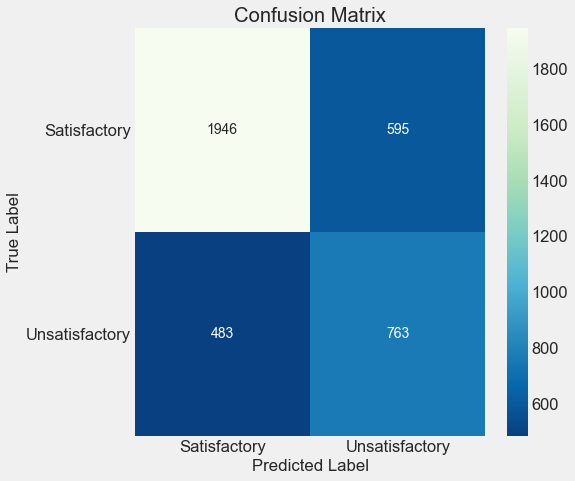

,Accuracy,F1,Recall,Precision
0,0.715342,0.586022,0.61236,0.561856


time: 708 ms


In [107]:
%%capture --no-display
f.confusion_report_nn(nn_sm, X_test, y_test)

## Model Summary

In [108]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,lsvc_ss,0.749032,0.535180,0.439393,0.684897,3.675846,Linear SVC SS()
1,svc_ss,0.758099,0.549220,0.447957,0.709744,26.867174,Support Vector CLF SS()
2,logreg_ss,0.751232,0.547893,0.458389,0.681355,8.969244,LogReg SS()
3,knn_ss,0.727025,0.536347,0.480068,0.607636,4.067252,KNN SS()
4,bclf_ss,0.759243,0.575552,0.496124,0.685570,2.703265,Bagging CLF SS()
12,nn_ss,0.754401,0.579999,0.516498,0.664783,16.549838,Neural Net SS()/SMOTE
5,nn_ss,0.757218,0.584370,0.521733,0.671488,16.289780,Neural Net SS()
6,rf_ss,0.772799,0.602838,0.524224,0.709531,6.399464,Random Forest SS()
7,vc_ss,0.776673,0.610678,0.532519,0.716097,14.864630,Voting CLF SS()
8,ada_ss,0.692165,0.539550,0.548302,0.531154,0.808926,AdaBoost SS()


time: 16.1 ms


In [109]:
%%capture --no-display
Audio(sound_file, autoplay=True)

time: 6.82 ms
